In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/'My Drive'/'Divar Task'

/content/drive/My Drive/Divar Task


In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
%matplotlib inline
import seaborn as sns

In [4]:
df = pd.read_excel("Summer Camp Task Data.xlsx", engine='openpyxl')
df

,action,created_at,source_event_id,device_id,post_page_offset,tokens,post_index_in_post_list,post_token
0,load_post_page,1609545001150,1575558c-a702-46ef-8e18-bc5cef761473,Ed9EADRZRXCHcrcEP_Hnkg,26.0,"[wXvP3enu, wXvHXzUS, wXvPHXVe, wXvPHRs3, wXvH3...",NaN,NaN
1,load_post_page,1609545121641,0fd004f4-ce9b-4766-ac96-7578dedebacb,5aVIp_PNSAWxqwBETYpmxQ,19.0,"[wXujANbk, wXurAJsf, wXufwlh1, wXtr_4tD, wXujg...",NaN,NaN
2,load_post_page,1609545009147,479905f2-3bb4-4c90-8e88-5ce4b60d0a73,mt0UAT4AQe2dECdXBvKYBA,0.0,"[wXvHbNqU, wXvDrof9, wXv_aXHk, wXvDrSIa, wXv_a...",NaN,NaN
3,load_post_page,1609546776979,b9b609bd-a486-42fb-b1a9-5ca03cf4a215,huSKUX-mSwyUcGzgSbXX6g,0.0,"[wXvb7cpv, wXvH3hL0, wXvjmDaE, wXvT0sOS, wXv_j...",NaN,NaN
4,load_post_page,1609547182717,6c390fce-34b6-4e19-837e-6bc295a72514,sL5fLDdoR9a7aDGPP8N-jA,1.0,"[wXvjJTIc, wXvb5_SX, wXvb54Gs, wXvb5t6J, wXvbJ...",NaN,NaN
...,...,...,...,...,...,...,...,...
111078,load_post_page,1609546941659,f55b2133-4f95-4cc5-8d18-1b47bd3dca63,hiJArdXuQ_a3zVxEsmkDjQ,0.0,"[wXv3qoPQ, wXvT7ylu, wXvnIJuH, wXvXH7vy, wXvDX...",NaN,NaN
111079,load_post_page,1609547257051,14282fc7-f431-43b6-8c07-423f33be3d74,NaN,1.0,"[wXYr2lVk, wXXj7iDP, wXXXIsQr, wXQbXKz6, wXN3t...",NaN,NaN
111080,load_post_page,1609546292003,0a859885-a19b-4420-a9e4-2259eca6765d,g0IAfhwXTYa5rdrk96jXFQ,9.0,"[wXr_jZmX, wXr7D0AM, wXrzjhxL, wXrfjQNe, wXrni...",NaN,NaN
111081,load_post_page,1609546304942,4ec64b79-27c4-4fba-b84c-b877dc82970a,TzlVSQK7S16V0TPyGELMKQ,0.0,"[wXv3aQrv, wXvn6ONM, wXvfaG0M, wXvf6LIr, wXvjJ...",NaN,NaN


In [5]:
df["created_at"] = pd.to_datetime(pd.to_datetime(df["created_at"], unit="ms").dt.strftime("%Y-%m-%d %H:%M:%S"))

In [6]:
load_df = df[df["action"] == "load_post_page"]
click_df = df[df["action"] == "click_post"]

In [7]:
click_df_nan = click_df.isna().sum()
nan_tokens = click_df_nan["tokens"]
nan_offsets = click_df_nan["post_page_offset"]
assert(nan_tokens == nan_offsets == click_df.shape[0])

In [8]:
load_df_nan = load_df.isna().sum()
nan_indices = load_df_nan["post_index_in_post_list"]
nan_post_tokens = load_df_nan["post_token"]
assert(nan_indices == nan_post_tokens == load_df.shape[0])

In [9]:
load_df = load_df.drop(["action", "post_index_in_post_list", "post_token"], axis=1)
load_df["post_page_offset"] = load_df["post_page_offset"].astype(np.int16)

In [10]:
click_df = click_df.drop(["action", "post_page_offset", "tokens"], axis=1)
click_df.post_index_in_post_list = click_df.post_index_in_post_list.astype(np.int16)

In [ ]:
# Uncomment to save dataframes locally!

# load_df.to_csv("load.csv")
# click_df.to_csv("click.csv")

# **Pre-processing**

### Duplicate rows (Question 1)

In [11]:
print(f"Total number of duplicate rows in load_df = {load_df.duplicated().sum()}")
print(f"Total number of duplicate rows in click_df = {click_df.duplicated().sum()}")

Total number of duplicate rows in load_df = 26
Total number of duplicate rows in click_df = 47


In [12]:
load_df.drop_duplicates(inplace=True)
click_df.drop_duplicates(inplace=True)

### Getting tokens' length

In [13]:
load_df["tokens"] = load_df.tokens.apply(lambda x: x[1:-1].replace(' ', '').split(','))

In [14]:
load_df["tokens_len"] = load_df.tokens.apply(len)

# **IN ORDER TO RUN THE REST, PLEASE RUN QUESTION 1 SECTION BEFORE OTHER PARTS.**

# **Data Exploration**

### Number of queries based on minutely timestamp

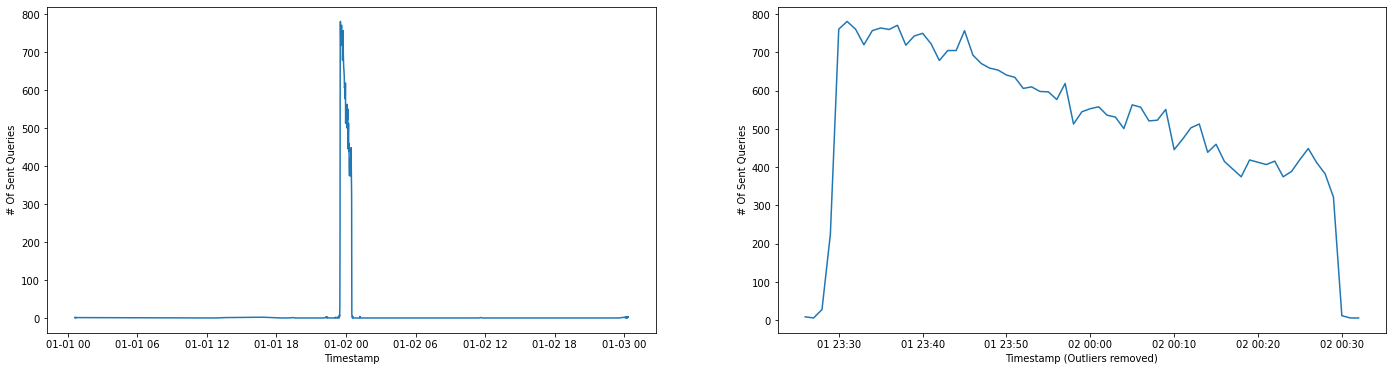

In [24]:
# Calculate total number of queries at each timestamp
query_count = load_df[["created_at", "source_event_id"]]
query_count["created_at"] = pd.to_datetime(query_count["created_at"].dt.strftime("%Y-%m-%d %H:%M"))
query_count = query_count.groupby("created_at", as_index=False).count()
query_count = query_count.rename(columns={'source_event_id': 'count'})

# Outliers removed
clean = query_count[query_count["count"] > 5]

fig, ax = plt.subplots(figsize = (24,6))

plt.subplot(1, 2, 1)
ax = sns.lineplot(data=query_count, x="created_at", y="count")
ax.set(xlabel='Timestamp', ylabel='# Of Sent Queries')

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=clean, x="created_at", y="count")
ax.set(xlabel='Timestamp (Outliers removed)', ylabel='# Of Sent Queries')

plt.show()

### CTR percentage based on each group (group = latest loaded page offset)

In [25]:
grouped = load_df.groupby(["source_event_id", "device_id"], as_index=False)
g = grouped.max()
g_sum = grouped.sum()
rrange = []
g_ctr_perc = []
g_num_queries = []

for i in range(load_df.post_page_offset.max()):
    # Unique queries in group i
    g_list = g[g.post_page_offset == i].source_event_id.unique()
    # Ideal total number of tokens loaded
    ideal_total = g_list.shape[0] * (i + 1) * 24
    # How many of group i queries were actually clicked?
    g_clicked = click_df[click_df.source_event_id.isin(g_list)].groupby(["source_event_id", "device_id"], as_index=False).count().post_index_in_post_list.sum()
    # Calculate CTR
    g_ctr = g_clicked / ideal_total
    if not np.isnan(g_ctr):
        rrange.append(i)
        g_ctr_perc.append(round(g_ctr, 3) * 100)
        g_num_queries.append(g_list.shape[0])

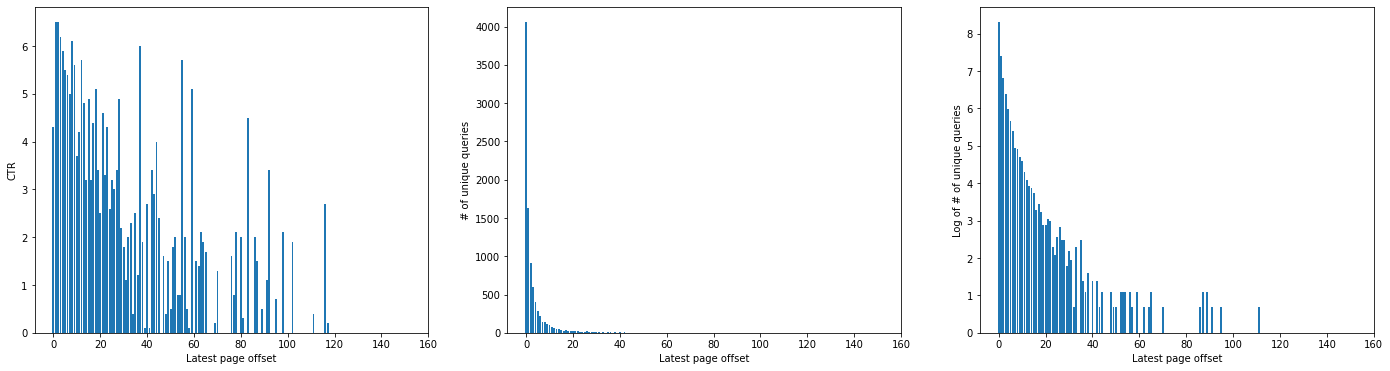

In [26]:
fig, ax = plt.subplots(figsize = (24, 6))

plt.subplot(1, 3, 1)
plt.bar(x = rrange, height = g_ctr_perc)
ax.set(xlabel='Latest page offset', ylabel='CTR percentage')
plt.xlabel('Latest page offset')
plt.ylabel('CTR')

plt.subplot(1, 3, 2)
plt.bar(x = rrange, height = g_num_queries)
ax.set(xlabel='Latest page offset', ylabel='# of queries')
plt.xlabel('Latest page offset')
plt.ylabel('# of unique queries')

plt.subplot(1, 3, 3)
plt.bar(x = rrange, height = np.log(g_num_queries))
ax.set(xlabel='Latest page offset', ylabel='# of queries')
plt.xlabel('Latest page offset')
plt.ylabel('Log of # of unique queries')

plt.show()

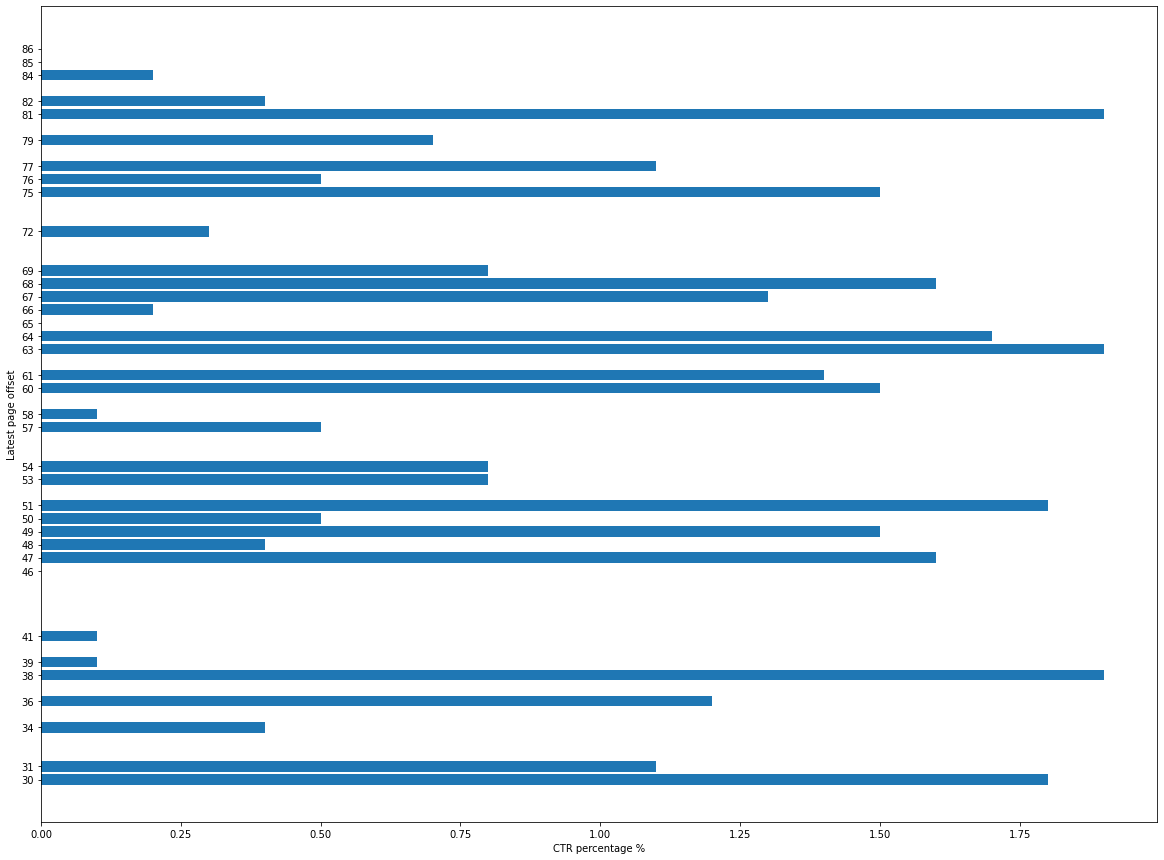

In [27]:
fig, ax = plt.subplots(figsize = (20, 15))

low_ctr_indices = [i for i in range(len(rrange)) if g_ctr_perc[i] < 2]
low_ctr_values = [g_ctr_perc[i] for i in range(len(rrange)) if g_ctr_perc[i] < 2]

plt.barh(y = low_ctr_indices, width = low_ctr_values)
ax.set(ylabel='Latest page offset', xlabel='CTR percentage %')
ax.set_yticks(low_ctr_indices)

plt.show()

### CTR percentage of tokens

In [28]:
all_clicked_tokens = click_df.post_token
clicked_unq_tokens, clicked_unq_tokens_cnt = np.unique(all_clicked_tokens, return_counts=True)
clicked_unq_tokens_counter = dict(zip(clicked_unq_tokens, clicked_unq_tokens_cnt))
clicked_unq_df = pd.DataFrame(data=clicked_unq_tokens_counter.items(), columns=["token", "clicked_count"])
clicked_unq_df

,token,clicked_count
0,6s-aL4tmC,1
1,AX9aGeoq,2
2,AXJjWaLL,1
3,AXXLcqma,2
4,AX_v3njs,1
...,...,...
33532,wXzupeZ3,1
33533,wXzxBirX,1
33534,wXzyYeu4,1
33535,wXzyn9tC,4


In [29]:
all_loaded_tokens = np.concatenate(load_df.tokens.to_numpy())
loaded_unq_tokens, loaded_unq_tokens_cnt = np.unique(all_loaded_tokens, return_counts=True)
loaded_unq_tokens_counter = dict(zip(loaded_unq_tokens, loaded_unq_tokens_cnt))
loaded_unq_df = pd.DataFrame(data=loaded_unq_tokens_counter.items(), columns=["token", "loaded_count"])
loaded_unq_df

,token,loaded_count
0,-EfhlclYd,4
1,0MKrzQKFq,1
2,0UkcHhzvn,1
3,0WJQi3Y-R,4
4,0aFSrrpBO,1
...,...,...
375375,y1zDieGuM,1
375376,y4DdYFew8,1
375377,yUJXZG40e,1
375378,yeDFIyNkj,1


In [30]:
merged = pd.merge(loaded_unq_df, clicked_unq_df, on="token", how="left", suffixes=["_shown", "_clicked"]).fillna(0, axis=1)
merged["ctr"] = 100 * round(merged.clicked_count / merged.loaded_count, 5)
merged = merged[merged.ctr <= 100]
merged

,token,loaded_count,clicked_count,ctr
0,-EfhlclYd,4,0.0,0.0
1,0MKrzQKFq,1,0.0,0.0
2,0UkcHhzvn,1,0.0,0.0
3,0WJQi3Y-R,4,0.0,0.0
4,0aFSrrpBO,1,0.0,0.0
...,...,...,...,...
375375,y1zDieGuM,1,0.0,0.0
375376,y4DdYFew8,1,0.0,0.0
375377,yUJXZG40e,1,0.0,0.0
375378,yeDFIyNkj,1,0.0,0.0


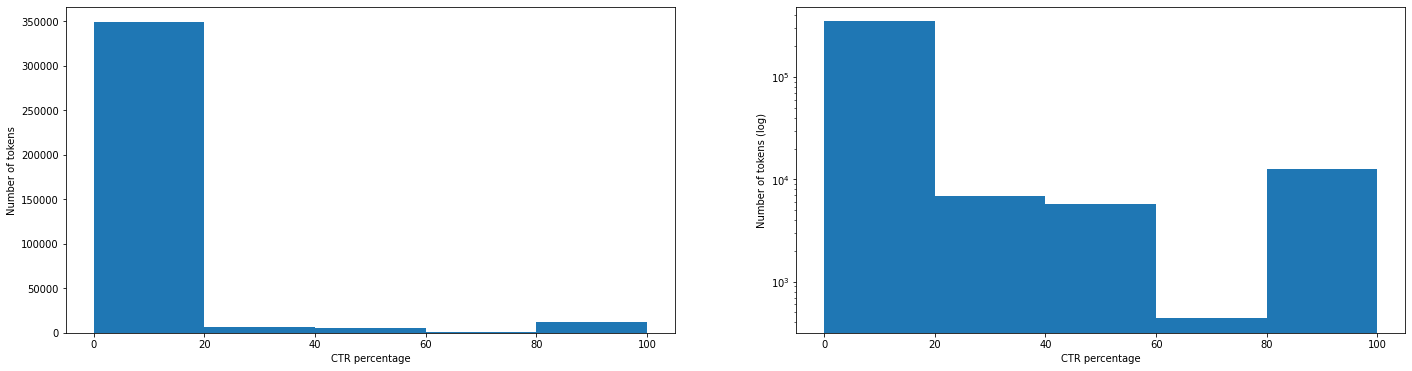

In [31]:
fig, ax = plt.subplots(figsize = (24, 6))

plt.subplot(1, 2, 1)
plt.hist(merged.ctr, bins=5)
plt.xlabel('CTR percentage')
plt.ylabel('Number of tokens')

plt.subplot(1, 2, 2)
plt.hist(merged.ctr, bins=5)
plt.yscale('log', nonposy='clip')
plt.xlabel('CTR percentage')
plt.ylabel('Number of tokens (log)')

plt.show()

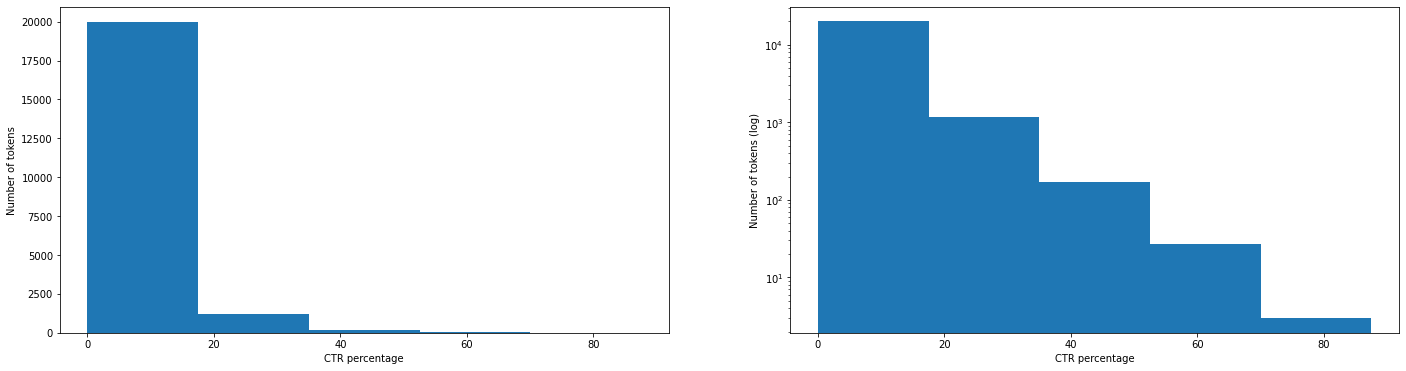

In [32]:
fig, ax = plt.subplots(figsize = (24, 6))

plt.subplot(1, 2, 1)
plt.hist(merged[merged.loaded_count > 5].ctr, bins=5)
plt.xlabel('CTR percentage')
plt.ylabel('Number of tokens')

plt.subplot(1, 2, 2)
plt.hist(merged[merged.loaded_count > 5].ctr, bins=5)
plt.yscale('log', nonposy='clip')
plt.xlabel('CTR percentage')
plt.ylabel('Number of tokens (log)')

plt.show()

### Queries with only one loaded page

In [33]:
one_pagers = load_df.groupby("source_event_id", as_index=False).max()
one_pagers = one_pagers[one_pagers.post_page_offset == 0]
one_pagers_unq_queries = one_pagers.source_event_id.unique()

In [34]:
is_clicked = click_df[click_df.source_event_id.isin(one_pagers_unq_queries)]
result = is_clicked.groupby("source_event_id", as_index=False).count()
result = result[["source_event_id"]]
result

,source_event_id
0,0057b345-8ad7-4c41-9e74-415e39a3140c
1,00796d71-0256-4241-810e-27f946f402ac
2,008faa8d-6648-42de-a76e-e0a7a97be360
3,009e2d57-d038-4268-9ec4-d021e6894667
4,00b3bd08-7d2c-4f1f-ba7b-f9e44012660f
...,...
1673,ff08b22a-c50e-4241-a9b7-d8a485d34b91
1674,ff804753-8238-4b4e-94ad-bbeec59d3aac
1675,ffb96e50-89ea-4a19-b804-b18b08ce1864
1676,ffbc107f-45f5-4dcf-b496-ce421de644a4


### Which queries' first results weren't clicked?

In [35]:
result = click_df.groupby(["source_event_id"], as_index=False).agg(lambda ser: np.count_nonzero(ser <= 3))
result = result[result.post_index_in_post_list == 0]
result = result[["source_event_id"]]
result

,source_event_id
3,005fd78b-bd9b-4075-bda3-1ea0f855c55c
5,00723aee-174a-4b00-83f8-78bd3918eb2c
6,0074a929-abce-4f2e-9da8-c02a1b0d137f
8,00796d71-0256-4241-810e-27f946f402ac
11,00b3bd08-7d2c-4f1f-ba7b-f9e44012660f
...,...
5805,ff85293f-215c-40bc-bcd5-4f6b4c08c796
5806,ffa7494d-38a3-47e1-a673-cfbfcc7bbfe1
5807,ffb96e50-89ea-4a19-b804-b18b08ce1864
5811,ffda8068-9c22-46f0-971e-6b2b19c764ea


# **Question 1**

### NaN values in device_id

In [15]:
load_df.isna().mean() * 100

created_at          0.000000
source_event_id     0.000000
device_id           1.443521
post_page_offset    0.000000
tokens              0.000000
tokens_len          0.000000
dtype: float64

In [16]:
click_df.isna().mean() * 100

created_at                 0.000000
source_event_id            0.000000
device_id                  1.291106
post_index_in_post_list    0.000000
post_token                 0.001320
dtype: float64

In [17]:
load_df.dropna(inplace=True)
click_df.dropna(inplace=True)

### post_page_offset column in load_df shouldn't have any gaps for a given query

In [18]:
no_token_list = load_df.drop(["tokens", "tokens_len"], axis=1).sort_values(["created_at", "post_page_offset"])
has_gap = lambda ser: np.any(np.diff(ser) > 1) or ser.iloc[0] != 0
apply = no_token_list.groupby(["source_event_id", "device_id"], as_index=False).agg(has_gap)
res = apply[apply.post_page_offset == True]

In [19]:
gapped_queries = res.source_event_id.unique()
all_queries = load_df.source_event_id.unique()
gapped_rows = load_df[load_df.source_event_id.isin(gapped_queries)]

In [20]:
load_df[load_df.source_event_id == gapped_queries[0]].sort_values("post_page_offset")

,created_at,source_event_id,device_id,post_page_offset,tokens,tokens_len
4129,2021-01-01 23:30:07,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,23,"[wXvr2A8C, wXvvGZdT, wXvvG0M0, wXvvWhO-, wXvr2...",24
69059,2021-01-01 23:31:51,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,24,"[wXv_T-3o, wXvXG0zy, wXvD0JbH, wXvDEPIa, wXvjm...",24
69966,2021-01-01 23:33:00,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,25,"[wXvTmLKA, wXvX2x9N, wXvXGhTf, wXvTmDCP, wXvPm...",24
2722,2021-01-01 23:33:38,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,26,"[wXvDW5Oi, wXvL2e-U, wXvTksZM, wXvL2Scr, wXvP2...",24
62536,2021-01-01 23:34:31,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,27,"[wXvHmvll, wXv7V6te, wXvT08vC, wXvXEV20, wXvXU...",24
54121,2021-01-01 23:35:48,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,28,"[wXvrUNj9, wXvzl2FO, wXv7lpq0, wXv7llb0, wXv7F...",24
109018,2021-01-01 23:37:47,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,29,"[wXv3VHVf, wXvr1-L6, wXvr0YL4, wXvrlqu-, wXv3F...",24
66083,2021-01-01 23:38:20,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,30,"[wXmXjoGo, wXvnF7IF, wXvnVMVO, wXvf1Vt2, wXvf1...",24
91600,2021-01-01 23:39:04,013a873e-0039-45fe-93e8-d6880077b6ce,39OT25_ZRzS9olIvPAVOsg,31,"[wXvHFPMJ, wXvn1zCP, wXvn1QkX, wXvflH6m, wXvPF...",24


In [21]:
print(f"Total number of gapped queries is {gapped_queries.shape[0]} which is %{100 * round(gapped_queries.shape[0] / all_queries.shape[0], 5)} of total queries.")
print(f"Total number of gapped rows is {gapped_rows.shape[0]} which is %{100 * round(gapped_rows.shape[0] / load_df.shape[0], 3)} of the load_df length.")

Total number of gapped queries is 628 which is %6.802 of total queries.
Total number of gapped rows is 5087 which is %14.6 of the load_df length.


### Some queries in click_df are not in load_df

In [22]:
clicked_unique_ids = click_df.source_event_id.unique()
loaded_unique_ids = load_df.source_event_id.unique()
result = np.setdiff1d(clicked_unique_ids, loaded_unique_ids)
print(f"There are in total {clicked_unique_ids.shape[0]} unique queries in click_df and %{100 * round(result.shape[0] / clicked_unique_ids.shape[0], 5)} of them are not in the load_df.")

There are in total 10649 unique queries in click_df and %45.413 of them are not in the load_df.


In [23]:
click_df = click_df[~click_df.source_event_id.isin(result)]
print(f"click_df now has {click_df.shape[0]} rows.")

click_df now has 41652 rows.


### Timestamp outlier

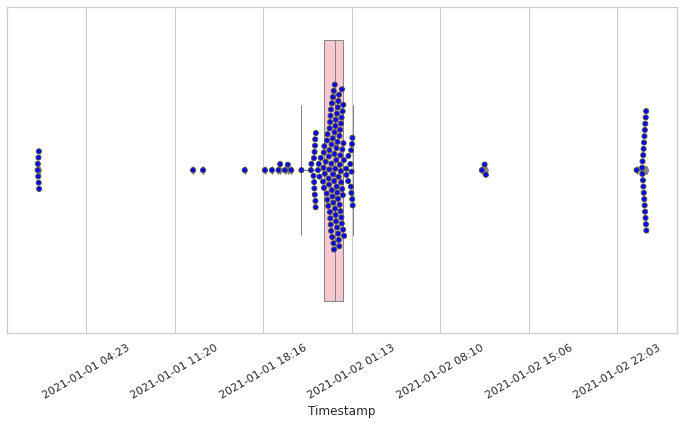

In [94]:
import time
from matplotlib.cbook import boxplot_stats


@plt.FuncFormatter
def convert_to_date_string(x,pos):
    return time.strftime("%Y-%m-%d %H:%M", time.localtime(x))


plt.figure(figsize=(12, 6))
temp = query_count.created_at.astype(np.int64)/1E9
ax = sns.boxplot(x=temp, color="pink", linewidth=1)
ax = sns.swarmplot(x=temp, color="blue", linewidth=1)
ax.xaxis.set_major_formatter(convert_to_date_string)
ax.set(xlabel='Timestamp')
plt.xticks(rotation=30);

In [99]:
stats = boxplot_stats(query_count.created_at.astype(np.int64))
outliers = [y / 1E9 for stat in stats for y in stat['fliers']]
outliers = [convert_to_date_string(o) for o in outliers]
outliers[:5]

['2021-01-01 00:36',
 '2021-01-01 00:37',
 '2021-01-01 00:39',
 '2021-01-01 00:40',
 '2021-01-01 00:41']

# **Question 2**

### Part 1 (Dark Query Percentage)

In [36]:
f = load_df[(load_df.tokens_len < 10) & (load_df.post_page_offset == 0)].source_event_id.nunique()
b = load_df.source_event_id.nunique()
print(f"Dark Query Percentage is {100 * round(f / b, 3)}")

Dark Query Percentage is 12.4


### Part 2 (Query Bounce Rate)

In [37]:
clicked_unique_ids = click_df.source_event_id.unique()
loaded_unique_ids = load_df.source_event_id.unique()
result = np.setdiff1d(loaded_unique_ids, clicked_unique_ids)
print(f"Query Bounce Rate is %{100 * round(result.shape[0] / loaded_unique_ids.shape[0], 3)}.")

Query Bounce Rate is %37.0.


# **Question 3**

In [38]:
max_offset = load_df.drop("tokens", axis=1).groupby("source_event_id", as_index=False).max().drop(["device_id", "created_at", "tokens_len"], axis=1)
merged = pd.merge(max_offset, load_df.drop(["created_at", "device_id", "tokens"], axis=1), on=["source_event_id", "post_page_offset"], how="left", suffixes=["_min", "_max"])
merged = merged.groupby("source_event_id", as_index=False).max()
merged["new"] = 24 * merged.post_page_offset + merged.tokens_len

In [39]:
tty = click_df.drop(["created_at", "device_id", "post_token"], axis=1).groupby(["source_event_id"], as_index=False).max()
merged_with_click = pd.merge(merged, tty, on="source_event_id", how="left", suffixes=["_min", "_max"]).fillna(0, axis=1)
merged_with_click["result"] = np.maximum(merged_with_click.post_index_in_post_list, merged_with_click.new)
merged_with_click = merged_with_click[["source_event_id", "result"]]

In [40]:
clicked_count = click_df.drop_duplicates().groupby(["source_event_id"], as_index=False).count()
clicked_count["res"] = clicked_count.created_at
clicked_count.drop(["device_id", "created_at", "post_index_in_post_list", "post_token"], axis=1, inplace=True)
clicked_count

,source_event_id,res
0,0017c208-e016-4231-a022-598ba020f1ff,4
1,004dc60d-2288-453f-bcda-1ad5e8d8211f,3
2,0057b345-8ad7-4c41-9e74-415e39a3140c,1
3,005fd78b-bd9b-4075-bda3-1ea0f855c55c,11
4,006bea27-8a2f-4453-a5f3-55d80a2b88c0,2
...,...,...
5808,ffb9b334-581a-4abd-9136-f78756e161f0,4
5809,ffbc107f-45f5-4dcf-b496-ce421de644a4,1
5810,ffd325c8-31c7-4e35-a5ed-ee922594e799,3
5811,ffda8068-9c22-46f0-971e-6b2b19c764ea,2


In [41]:
final = pd.merge(merged_with_click, clicked_count, on="source_event_id", how="left")
final.fillna(0, inplace=True)
final["res"] = final.res / final.result
final

,source_event_id,result,res
0,00049ef3-c027-4f55-869c-46711f0ea0ad,24.0,0.000000
1,00069dda-4175-4bb0-8ef0-c0e1031d4da6,24.0,0.000000
2,0017c208-e016-4231-a022-598ba020f1ff,96.0,0.041667
3,002222cf-9e4b-4432-9e36-ad500a753850,24.0,0.000000
4,004dc60d-2288-453f-bcda-1ad5e8d8211f,25.0,0.120000
...,...,...,...
9228,ffd325c8-31c7-4e35-a5ed-ee922594e799,17.0,0.176471
9229,ffda8068-9c22-46f0-971e-6b2b19c764ea,216.0,0.009259
9230,ffeaa17f-ee79-4f42-be58-afd60a5aef37,48.0,0.000000
9231,ffec4e11-c0a1-4fa4-8613-0979d6f46918,528.0,0.009470


In [42]:
answer = final[final.res < 1].res.mean()
print(f"The average click rate of queries is %{100 * round(answer, 3)}.")

The average click rate of queries is %7.1.
